In [1]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import pickle
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import utils
from torchvision.models import list_models

from cat_vs_dog_helpers import train, evalf, experiment_pipeline, plot_results

## Load Data

In [2]:
data = torch.load("cat_vs_dog_data.pt")
labels = torch.load("cat_vs_dog_labels.pt").reshape((-1,1))

In [3]:
data.shape

torch.Size([25000, 3, 100, 100])

- data is transformed into 100x100 rgb images

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# Pretrained models in Pytorch

In [5]:
list_models()

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

Models:
- Alexnet
- VGG19BN
- InceptionV3
- DenseNet
- Resnet
- MobileNetV3

## AlexNet

Using cache found in C:\Users\erdem/.cache\torch\hub\pytorch_vision_v0.10.0
100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:29<00:00, 18.40it/s]


Epoch-1:
Train Accuracy: 80.47428894042969
Train Loss: 0.3263627886772156


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:26<00:00, 20.51it/s]


Epoch-2:
Train Accuracy: 81.9028549194336
Train Loss: 0.37319719791412354


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:26<00:00, 20.47it/s]


Epoch-3:
Train Accuracy: 82.57142639160156
Train Loss: 0.3463220000267029


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:26<00:00, 20.47it/s]


Epoch-4:
Train Accuracy: 82.82286071777344
Train Loss: 0.6017994284629822


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:26<00:00, 20.50it/s]


Epoch-5:
Train Accuracy: 83.04000091552734
Train Loss: 0.27381500601768494


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [01:28<00:00, 85.22it/s]


Test Accuracy: 86.42666625976562


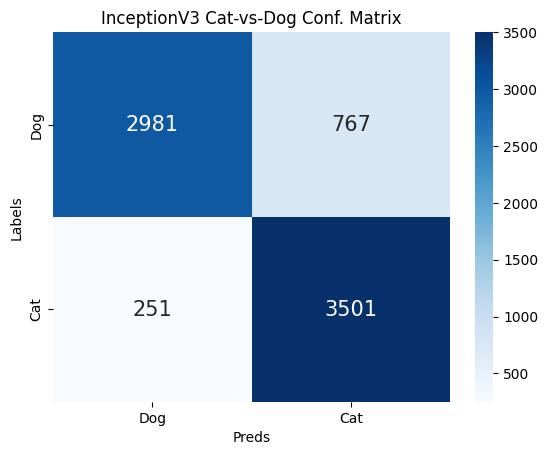

In [6]:
class AlexNetBackboned(nn.Module):
    def __init__(self):
        super(AlexNetBackboned, self).__init__()
        # Load pretrained alexnet
        self.alexnet = torch.hub.load("pytorch/vision:v0.10.0", "alexnet", weights="DEFAULT")

        # freezing the alexnet parameters
        for param in self.alexnet.parameters():
            param.requires_grad = False

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.bn1 = nn.BatchNorm1d(1000)
        self.linear1 = torch.nn.Linear(1000, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.linear2 = torch.nn.Linear(256, 1)

    def forward(self, x):


        x = self.alexnet(x)
        x = self.relu(self.bn1(x))
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.relu(self.bn2(x))
        x = self.dropout(x)
        x = self.linear2(x)

        return x
    
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
epochs = 5
input_size = 227

batch_size = 32

net = AlexNetBackboned().to(device)
optimizer = optim.Adam(net.parameters())
criterion = nn.BCEWithLogitsLoss()

start = time.time()

alexnet_evals = experiment_pipeline(net, X_train, y_train, X_test, y_test, optimizer,
                    criterion, batch_size, epochs, input_size, device)

alexnet_evals["experiment_time"] = time.time() - start

torch.save(alexnet_evals, "alexnet_results.pt")
torch.save(net, "alexnet_model.pt")

## VGG19-BN

Using cache found in C:\Users\erdem/.cache\torch\hub\pytorch_vision_v0.10.0
100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:05<00:00,  4.35it/s]


Epoch-1:
Train Accuracy: 94.98285675048828
Train Loss: 0.16567333042621613


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:06<00:00,  4.34it/s]


Epoch-2:
Train Accuracy: 95.53142547607422
Train Loss: 0.016615822911262512


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:06<00:00,  4.33it/s]


Epoch-3:
Train Accuracy: 95.95428466796875
Train Loss: 0.14461231231689453


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:06<00:00,  4.33it/s]


Epoch-4:
Train Accuracy: 96.0857162475586
Train Loss: 0.03655537962913513


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:06<00:00,  4.33it/s]


Epoch-5:
Train Accuracy: 96.24000549316406
Train Loss: 0.027001505717635155


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [02:00<00:00, 62.21it/s]


Test Accuracy: 97.33333587646484


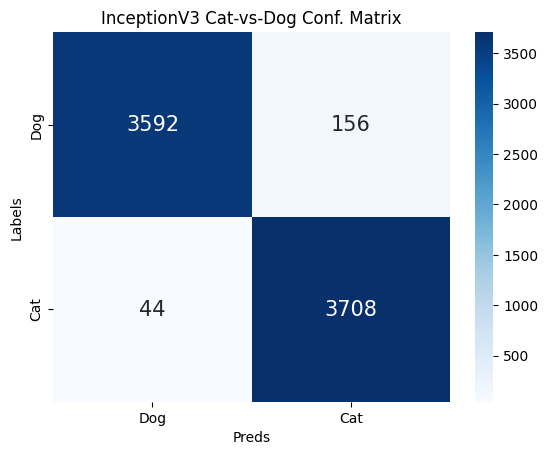

In [13]:
class VGG19BNBackboned(nn.Module):
    def __init__(self):
        super(VGG19BNBackboned, self).__init__()
        # Load pretrained vgg19_bn
        self.vgg19_bn = torch.hub.load("pytorch/vision:v0.10.0", "vgg19_bn", weights="DEFAULT")

        # freezing the vgg parameters
        for param in self.vgg19_bn.parameters():
            param.requires_grad = False

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.bn1 = nn.BatchNorm1d(1000)
        self.linear1 = torch.nn.Linear(1000, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.linear2 = torch.nn.Linear(256, 1)

    def forward(self, x):


        x = self.vgg19_bn(x)
        x = self.relu(self.bn1(x))
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.relu(self.bn2(x))
        x = self.dropout(x)
        x = self.linear2(x)

        return x
    
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 5
input_size = 224

batch_size = 32

net = VGG19BNBackboned().to(device)
optimizer = optim.Adam(net.parameters())
criterion = nn.BCEWithLogitsLoss()

start = time.time()

vgg_evals = experiment_pipeline(net, X_train, y_train, X_test, y_test, optimizer,
                    criterion, batch_size, epochs, input_size, device)

vgg_evals["experiment_time"] = time.time() - start

torch.save(vgg_evals, "vgg19_bn_results.pt")
torch.save(net, "vgg19_bn_model.pt")

## InceptionV3

Using cache found in C:\Users\erdem/.cache\torch\hub\pytorch_vision_v0.10.0
100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:28<00:00,  3.69it/s]


Epoch-1:
Train Accuracy: 94.95428466796875
Train Loss: 0.14774613082408905


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:27<00:00,  3.70it/s]


Epoch-2:
Train Accuracy: 95.5771484375
Train Loss: 0.28733962774276733


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:20<00:00,  3.90it/s]


Epoch-3:
Train Accuracy: 95.6971435546875
Train Loss: 0.08782760053873062


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:20<00:00,  3.90it/s]


Epoch-4:
Train Accuracy: 96.182861328125
Train Loss: 0.08355781435966492


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:20<00:00,  3.90it/s]


Epoch-5:
Train Accuracy: 96.01714324951172
Train Loss: 0.08827053010463715


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [02:02<00:00, 61.35it/s]


Test Accuracy: 97.37333679199219


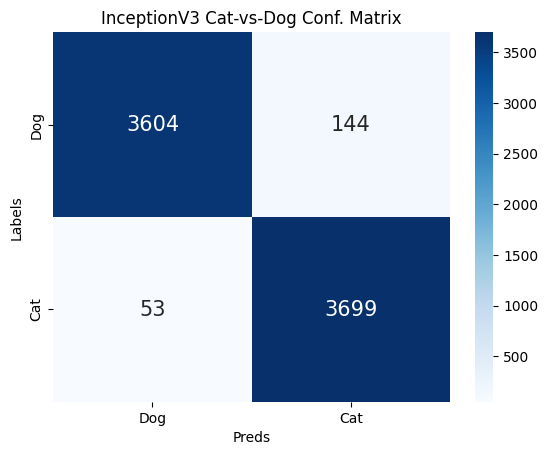

In [8]:
class InceptionV3Backboned(nn.Module):
    def __init__(self):
        super(InceptionV3Backboned, self).__init__()
        # Load pretrained InceptionV3
        self.inceptionv3 = torch.hub.load("pytorch/vision:v0.10.0", "inception_v3", weights="DEFAULT")
        
        # some other thing related with inception model
        self.inceptionv3.aux_logits = False

        # freezing the inception parameters
        for param in self.inceptionv3.parameters():
            param.requires_grad = False

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.bn1 = nn.BatchNorm1d(1000)
        self.linear1 = torch.nn.Linear(1000, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.linear2 = torch.nn.Linear(256, 1)

    def forward(self, x):


        x = self.inceptionv3(x)
        x = self.relu(self.bn1(x))
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.relu(self.bn2(x))
        x = self.dropout(x)
        x = self.linear2(x)

        return x
    
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 5
input_size = 229

batch_size = 32

net = VGG19BNBackboned().to(device)
optimizer = optim.Adam(net.parameters())
criterion = nn.BCEWithLogitsLoss()

start = time.time()

inception_evals = experiment_pipeline(net, X_train, y_train, X_test, y_test, optimizer,
                    criterion, batch_size, epochs, input_size, device)

inception_evals["experiment_time"] = time.time() - start

torch.save(inception_evals, "inception_v3_results.pt")
torch.save(net, "inception_v3_model.pt")

## DenseNet

Using cache found in C:\Users\erdem/.cache\torch\hub\pytorch_vision_v0.10.0
100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:06<00:00,  4.31it/s]


Epoch-1:
Train Accuracy: 96.44000244140625
Train Loss: 0.02682405896484852


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:06<00:00,  4.32it/s]


Epoch-2:
Train Accuracy: 97.31428527832031
Train Loss: 0.1656486541032791


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:06<00:00,  4.32it/s]


Epoch-3:
Train Accuracy: 97.72000122070312
Train Loss: 0.016890352591872215


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:06<00:00,  4.33it/s]


Epoch-4:
Train Accuracy: 97.72000122070312
Train Loss: 0.022155923768877983


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [02:06<00:00,  4.33it/s]


Epoch-5:
Train Accuracy: 97.95428466796875
Train Loss: 0.008170857094228268


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [04:22<00:00, 28.60it/s]


Test Accuracy: 98.26667022705078


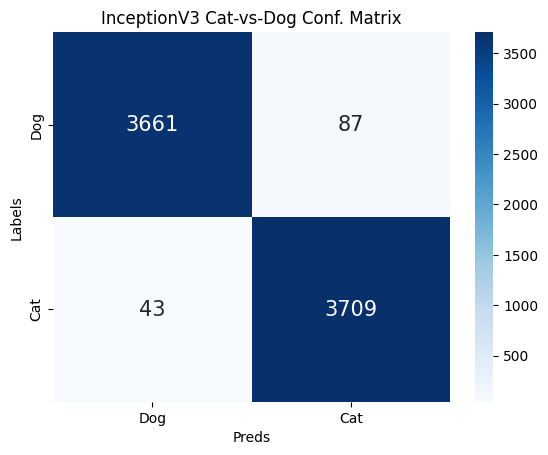

In [9]:
class DenseNetBackBoned(nn.Module):
    def __init__(self):
        super(DenseNetBackBoned, self).__init__()
        # Load pretrained densenet
        self.densenet = torch.hub.load("pytorch/vision:v0.10.0", "densenet161", weights="DEFAULT")

        # freezing the densenet parameters
        for param in self.densenet.parameters():
            param.requires_grad = False

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.bn1 = nn.BatchNorm1d(1000)
        self.linear1 = torch.nn.Linear(1000, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.linear2 = torch.nn.Linear(256, 1)

    def forward(self, x):


        x = self.densenet(x)
        x = self.relu(self.bn1(x))
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.relu(self.bn2(x))
        x = self.dropout(x)
        x = self.linear2(x)

        return x
    
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
epochs = 5
input_size = 224

batch_size = 32

net = DenseNetBackBoned().to(device)
optimizer = optim.Adam(net.parameters())
criterion = nn.BCEWithLogitsLoss()

start = time.time()

densenet_evals = experiment_pipeline(net, X_train, y_train, X_test, y_test, optimizer,
                    criterion, batch_size, epochs, input_size, device)

densenet_evals["experiment_time"] = time.time() - start

torch.save(densenet_evals, "densenet161_results.pt")
torch.save(net, "densenet161_model.pt")

## Resnet

Using cache found in C:\Users\erdem/.cache\torch\hub\pytorch_vision_v0.10.0
100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:54<00:00, 10.07it/s]


Epoch-1:
Train Accuracy: 94.82286071777344
Train Loss: 0.0736069530248642


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:54<00:00, 10.10it/s]


Epoch-2:
Train Accuracy: 96.36000061035156
Train Loss: 0.055422380566596985


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:54<00:00, 10.11it/s]


Epoch-3:
Train Accuracy: 96.21142578125
Train Loss: 0.06101767718791962


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:54<00:00, 10.10it/s]


Epoch-4:
Train Accuracy: 96.4857177734375
Train Loss: 0.016470089554786682


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:54<00:00, 10.07it/s]


Epoch-5:
Train Accuracy: 96.9142837524414
Train Loss: 0.010840230621397495


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [01:26<00:00, 86.58it/s]


Test Accuracy: 97.586669921875


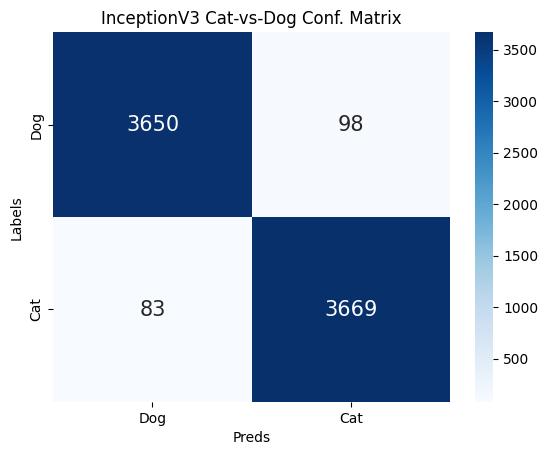

In [10]:
class ResnetBackBoned(nn.Module):
    def __init__(self):
        super(ResnetBackBoned, self).__init__()
        # Load pretrained resnet
        self.resnet = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", weights="DEFAULT")

        # freezing the resnet parameters
        for param in self.resnet.parameters():
            param.requires_grad = False

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.bn1 = nn.BatchNorm1d(1000)
        self.linear1 = torch.nn.Linear(1000, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.linear2 = torch.nn.Linear(256, 1)

    def forward(self, x):


        x = self.resnet(x)
        x = self.relu(self.bn1(x))
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.relu(self.bn2(x))
        x = self.dropout(x)
        x = self.linear2(x)

        return x
    
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
epochs = 5
input_size = 224

batch_size = 32

net = ResnetBackBoned().to(device)
optimizer = optim.Adam(net.parameters())
criterion = nn.BCEWithLogitsLoss()

start = time.time()

resnet_evals = experiment_pipeline(net, X_train, y_train, X_test, y_test, optimizer,
                    criterion, batch_size, epochs, input_size, device)

resnet_evals["experiment_time"] = time.time() - start

torch.save(resnet_evals, "resnet50_results.pt")
torch.save(net, "resnet50_model.pt")

## MobileNetV3

Using cache found in C:\Users\erdem/.cache\torch\hub\pytorch_vision_v0.10.0
100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:20<00:00, 26.40it/s]


Epoch-1:
Train Accuracy: 90.46857452392578
Train Loss: 0.1615372896194458


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:20<00:00, 26.76it/s]


Epoch-2:
Train Accuracy: 91.95428466796875
Train Loss: 0.35112687945365906


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:20<00:00, 26.95it/s]


Epoch-3:
Train Accuracy: 92.89143371582031
Train Loss: 0.08077649027109146


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:20<00:00, 27.28it/s]


Epoch-4:
Train Accuracy: 92.50285339355469
Train Loss: 0.123106449842453


100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:19<00:00, 27.39it/s]


Epoch-5:
Train Accuracy: 93.05714416503906
Train Loss: 0.23400309681892395


100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [01:35<00:00, 78.28it/s]


Test Accuracy: 95.2800064086914


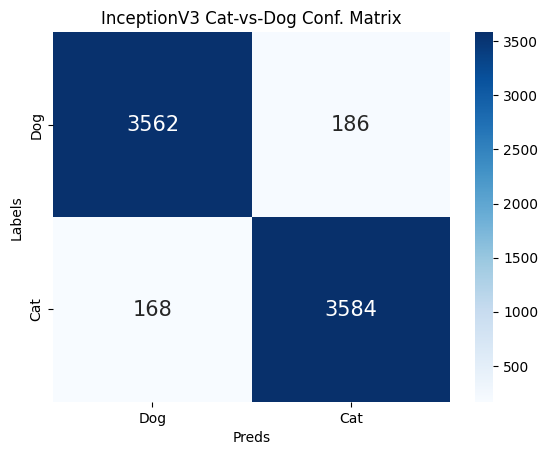

In [11]:
class MobileNetV3Backboned(nn.Module):
    def __init__(self):
        super(MobileNetV3Backboned, self).__init__()
        # Load pretrained mobilenet
        self.mobilenet = torch.hub.load("pytorch/vision:v0.10.0", "mobilenet_v3_large", weights="DEFAULT")## VGG19-BN

        # freezing the mobilenet parameters
        for param in self.mobilenet.parameters():
            param.requires_grad = False

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.bn1 = nn.BatchNorm1d(1000)
        self.linear1 = torch.nn.Linear(1000, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.linear2 = torch.nn.Linear(256, 1)

    def forward(self, x):


        x = self.mobilenet(x)
        x = self.relu(self.bn1(x))
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.relu(self.bn2(x))
        x = self.dropout(x)
        x = self.linear2(x)

        return x
    
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 5
input_size = 224

batch_size = 32

net = MobileNetV3Backboned().to(device)
optimizer = optim.Adam(net.parameters())
criterion = nn.BCEWithLogitsLoss()

start = time.time()

mobilenet_evals = experiment_pipeline(net, X_train, y_train, X_test, y_test, optimizer,
                    criterion, batch_size, epochs, input_size, device)

mobilenet_evals["experiment_time"] = time.time() - start

torch.save(mobilenet_evals, "mobilenet_v3_large_results.pt")
torch.save(net, "mobilenet_v3_large_model.pt")

# Results

In [12]:
mobilenet_model = torch.load("mobilenet_v3_large_model.pt")
test_accuracy, model_preds, true_labels, train_accuracies, train_losses, exp_time = torch.load("mobilenet_v3_large_results.pt")